# Topics - Easy Topic Modeling in Python

The text mining technique Topic Modeling has become a popular statistical method for clustering documents. This notebook introduces an user-friendly workflow, basically containing data preprocessing, an implementation of LDA (Latent Dirichlet Allocation) topic modeling which learns the relationships between words, topics, and documents, as well as a visualization to explore the trained LDA model.

#### Preperations

The following tutorial will explain how to perform LDA topic modeling with a programming library in Python. If you have not done so yet, please follow the instructions for installing jupyter and all necessary python libraries mentioned in readme.txt/installation_instructions.

Before you start, make sure to have Git and the Topics repository ready to use on your computer:
1. Download and install [Git](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git)
2. Open the [command-line interface](https://en.wikipedia.org/wiki/Command-line_interface), type `git clone https://github.com/DARIAH-DE/Topics.git` and press Enter
3. Access the new folder *topics* in your package explorer
4. To install the required packages, simply run `setup.py`
5. Install [Jupyter](http://jupyter.readthedocs.io/en/latest/install.html) and run it by typing `jupyter notebook` in the command-line
5. Access the folder **Topics** through Jupyter in your browser, open **IntroductionTopics.ipynb** and follow the instructions

## 1. Preprocessing

### 1.1. Loading modules

#### Loading modules from DARIAH-Topics library
First, we have to get access to the functionalities of the library by importing them. For using its functions we use the prefix of the toolbox's submodules (pre, visual and mallet).

In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import mallet as mal

#### Load required functions from Gensim
Furthermore, we will need some additional functions from external libraries.

In [2]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

#### Activating inline output in Jupyter notebook
The following line will just tell the notebook to show graphics in the output frames.

In [3]:
%matplotlib inline

### 1.2. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using a folder of 'txt' documents provided with the package. For using your own corpus, change the path accordingly.

In [4]:
path = "corpus_txt"

#### List all documents in the folder
We begin by creating a list of all the documents in the folder specified above. That list will tell function `pre.read_from_txt()` (see below) which text documents to read.

In [5]:
docs = pre.PathDocList(path)
doclist = docs.full_paths(as_str=True)

The current list of documents looks like this:

In [6]:
doclist

['corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt',
 'corpus_txt/Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt/Doyle_TheSignoftheFour.txt',
 'corpus_txt/Howard_GodsoftheNorth.txt',
 'corpus_txt/Howard_SchadowsinZamboula.txt',
 'corpus_txt/Howard_ShadowsintheMoonlight.txt',
 'corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Kipling_TheEndofthePassage.txt',
 'corpus_txt/Kipling_TheJungleBook.txt',
 'corpus_txt/Kipling_ThyServantaDog.txt',
 'corpus_txt/Lovecraft_AttheMountainofMadness.txt',
 'corpus_txt/Lovecraft_TheShunnedHouse.txt',
 'corpus_txt/Poe_EurekaAProsePoem.txt',
 'corpus_txt/Poe_TheCaskofAmontillado.txt',
 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt',
 'corpus_txt/Poe_ThePurloinedLetter.txt']

**Alternatively**, if we want to use other documents, or just a selction of those in the specified folder, we can define our own `doclist` by creating a list of strings containing paths to text files. For example, to use only the texts by Edgar A. Poe from the current folder, we would define the list as

`
    doclist = [ 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt', 
            'corpus_txt/Poe_TheCaskofAmontillado.txt', 
            'corpus_txt/Poe_ThePurloinedLetter.txt',
            'corpus_txt/Poe_ThePurloinedLetter.txt',
            'corpus_txt/Poe_EurekaAProsePoem.txt']
`

#### Generate document labels

In [7]:
doc_labels = docs.labels()
doc_labels

['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth',
 'Howard_SchadowsinZamboula',
 'Howard_ShadowsintheMoonlight',
 'Howard_TheDevilinIron',
 'Kipling_TheEndofthePassage',
 'Kipling_TheJungleBook',
 'Kipling_ThyServantaDog',
 'Lovecraft_AttheMountainofMadness',
 'Lovecraft_TheShunnedHouse',
 'Poe_EurekaAProsePoem',
 'Poe_TheCaskofAmontillado',
 'Poe_TheMasqueoftheRedDeath',
 'Poe_ThePurloinedLetter']

#### Read listed documents from folder

In [8]:
corpus = pre.read_from_txt(doclist)

At this point, the corpus is generator object.

### 1.3. Tokenize corpus
Your text files will be tokenized. Tokenization is the task of cutting a stream of characters into linguistic units, simply words or, more precisely, tokens. The tokenize function the library provides is a simple unicode tokenizer. Depending on the corpus it might be useful to use an external tokenizer function, or even develop your own, since its efficiency varies with language, epoch and text type.

In [9]:
doc_tokens = [list(pre.tokenize(doc)) for doc in list(corpus)]

At this point, each text is represented by a list of separate token strings. If we want to look e.g. into the first text (which has the index `0` as Python starts counting at 0) and show its first 10 words/tokens (that have the indeces `0:9` accordingly) by typing:

In [10]:
doc_tokens[0][0:9]

['scandal',
 'in',
 'bohemia',
 'conan',
 'doyle',
 'to',
 'sherlock',
 'holmes',
 'she']

### 1.4. Create a sparse bag-of-words model

The LDA topic model is based on a bag-of-words model of the corpus. To improve performance in large corpora, actual words and document titels are replaced by indices in the actual bag-of-words model. It is therefore necessary to create dictionaries for mapping these indices in advance.

#### Create dictionaries

In [11]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Create market matrix

In [12]:
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, id_types, doc_ids)

### 1.5. Feature selection and/or removal

In topic modeling, it is often usefull (if not vital) to remove some types before modeling. In this example, the 100 most frequent words and the *hapax legomena* in the corpus are listed and removed. Alternatively, the 'feature_list' containing all features to be removed from the corpus can be replaced by, or combined with an external stop word list or any other list of strings containing features we want to remove.

#### List the 100 most frequent words

In [13]:
mfw100 = pre.find_stopwords(sparse_bow, id_types, 100)

These are the five most frequent words:

In [14]:
mfw100[:5]

['the', 'and', 'of', 'to', 'in']

#### List hapax legomena

In [15]:
hapax_list = pre.find_hapax(sparse_bow, id_types)

#### Combine lists and remove content from bag-of-words model

In [16]:
feature_list = set(mfw100).union(hapax_list)
clean_term_frequency = pre.remove_features(sparse_bow, id_types, feature_list)

### 1.6. Save bag-of-words model

In [17]:
pre.save_sparse_bow(sparse_bow, "gb_plain")

## 2. Model creation

The actual topic modeling is done with external state-of-the-art LDA implementations. In this example, we are relying on the open-source toolkit **Gensim** which was used and cited in over 400 commercial and academic applications since 2008. As an alternative, the Java program **Mallet** can be used for LDA. Instruction on how to use Mallet can be found in the [Mallet notebook](Mallet.ipynb).

### 2.1. Load corpus object

In [18]:
mm = MmCorpus("gb_plain.mm")

### 2.2. Rearrange dictionaries 

In [19]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

### 2.3. Generate LDA model

We can define the number of topics we want to calculate as an argument in the function. Furthermore, the number of passes can be defined. A higher number of passes will probably yield a better model, but also increase processing time.

**Warning: this step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of passes. Our example short stories corpus should be done within a minute or two at 'passes = 10'.

In [20]:
model = LdaModel(corpus=mm, id2word=type2id, num_topics=10, passes=10, iterations=200)

### 2.4. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas data frame) that constitutes our principle exchange format for topic modeling results. For generating the matrix from a Gensim model, we can use the following function:

In [21]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

## 3. Model visualization and evaluation

Now we can see the topics in the model with the following function:

In [22]:
pre.gensim2dataframe(model)

,0,1,2,3,4,5,6,7,8,9
0,hideously,grieving,offspring,jumping-on,megalithic,disfavour,combs,scotland,swamp-bred,inorganic
1,grieving,hideously,jumping-on,offspring,megalithic,disfavour,inorganic,combs,swamp-bred,old-world
2,jumping-on,disfavour,offspring,grieving,receive,hideously,cheek,combs,toast,inorganic
3,grieving,hideously,offspring,jumping-on,megalithic,inorganic,toast,stamford,scotland,horseshoe
4,grieving,jumping-on,hideously,offspring,inorganic,disfavour,megalithic,old-world,swamp-bred,scotland
5,grieving,offspring,hideously,jumping-on,disfavour,megalithic,swamp-bred,combs,inorganic,scotland
6,grieving,offspring,jumping-on,disfavour,hideously,swamp-bred,megalithic,inorganic,receive,kushite
7,grieving,offspring,hideously,jumping-on,megalithic,disfavour,inorganic,scotland,combs,swamp-bred
8,grieving,offspring,jumping-on,disfavour,hideously,receive,megalithic,cheek,combs,scotland
9,offspring,receive,disfavour,jumping-on,grieving,combs,hideously,cheek,toast,irradiated


### 3.1. Distribution of topics

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in a heat map:

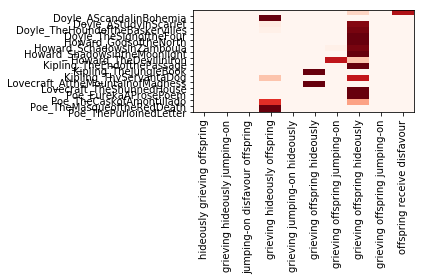

In [23]:
heatmap = visual.doc_topic_heatmap(doc_topic)
heatmap.show()

#### Distribution of topics in a single documents

To take closer look on the topics in a single text, we can use the follwing function that shows all the topics in a text and their respective proportions. To select the document, we have to give its index to the function.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

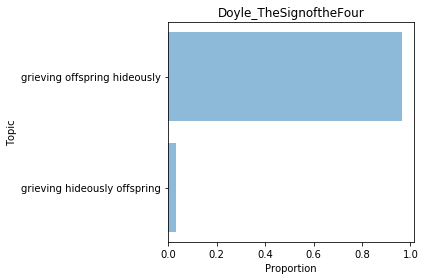

In [24]:
visual.plot_doc_topics(doc_topic, 3)